In [11]:
import pandas as pd
import numpy as np

np.random.seed(37)

df = pd.DataFrame({
    'p': np.arange(1, 20, 1) + 1.99,
    'q': np.exp(-0.1 * np.arange(1, 20, 1)) * 100.0 
})

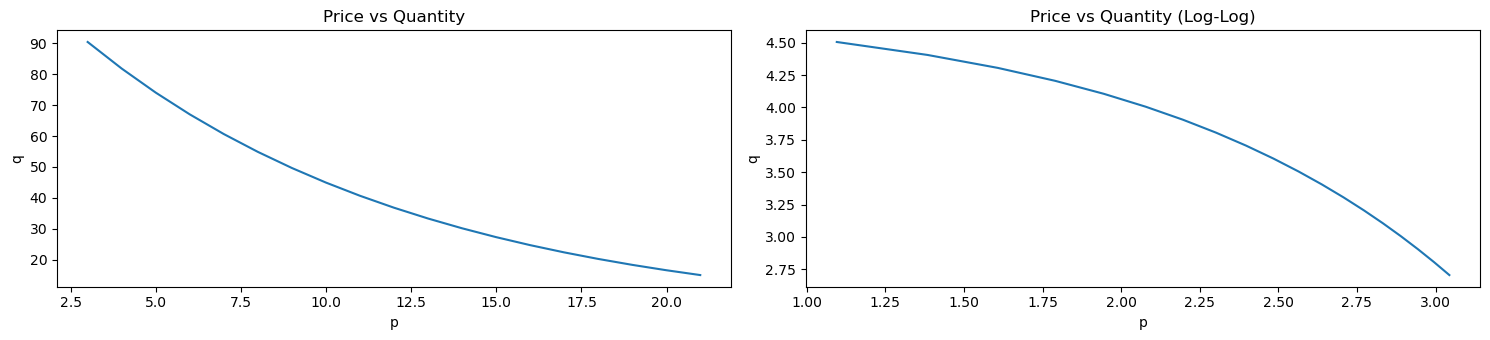

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 3.5))

df \
    .set_index(['p'])['q'] \
    .plot(kind='line', ylabel='q', title='Price vs Quantity', ax=ax[0])
np.log(df) \
    .set_index(['p'])['q'] \
    .plot(kind='line', ylabel='q', title='Price vs Quantity (Log-Log)', ax=ax[1])

fig.tight_layout()

## Elasticity

In [18]:
_temp1 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den']
    )

In [19]:
_temp2 = df \
    .assign(
        q_p=lambda d: d['q'].shift(-1),
        p_p=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_p'],
        d_p=lambda d: d['p'] - d['p_p'],
        num=lambda d: d['d_q'] / d['q'],
        den=lambda d: d['d_p'] / d['p'],
        ped=lambda d: d['num'] / d['den'],
        p=lambda d: d['p_p']
    )

<Axes: xlabel='p', ylabel='ped'>

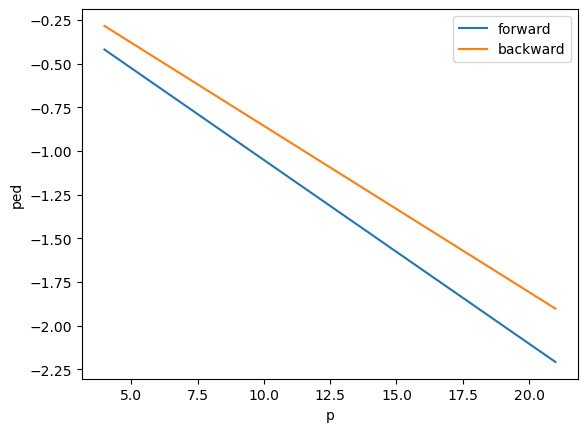

In [94]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .plot(kind='line', ylabel='ped')

## Arc elasticity

In [28]:
_temp3 = df \
    .assign(
        q_n=lambda d: d['q'].shift(1),
        p_n=lambda d: d['p'].shift(1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p'])
    )

In [29]:
_temp4 = df \
    .assign(
        q_n=lambda d: d['q'].shift(-1),
        p_n=lambda d: d['p'].shift(-1)
    ) \
    .dropna() \
    .assign(
        d_q=lambda d: d['q'] - d['q_n'],
        d_p=lambda d: d['p'] - d['p_n'],
        ped=lambda d: (d['p'] + d['p_n']) / (d['q'] + d['q_n']) * (d['d_q'] / d['d_p']),
        p=lambda d: d['p_n']
    )

<Axes: xlabel='p', ylabel='ped'>

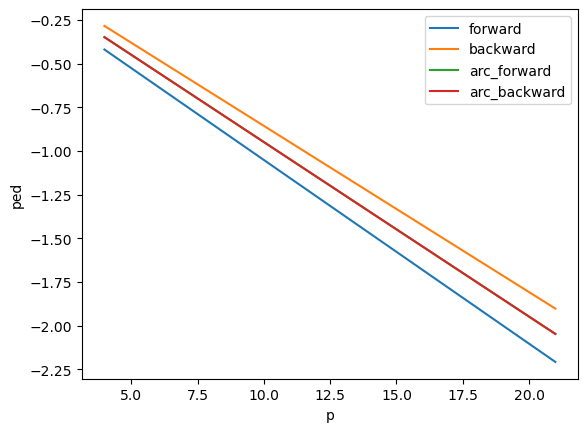

In [93]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .join(_temp3.set_index(['p']).rename(columns={'ped': 'arc_forward'})[['arc_forward']]) \
    .join(_temp4.set_index(['p']).rename(columns={'ped': 'arc_backward'})[['arc_backward']]) \
    .plot(kind='line', ylabel='ped')

In [31]:
_temp1.set_index(['p']).rename(columns={'ped': 'forward'})[['forward']] \
    .join(_temp2.set_index(['p']).rename(columns={'ped': 'backward'})[['backward']]) \
    .join(_temp3.set_index(['p']).rename(columns={'ped': 'arc_forward'})[['arc_forward']]) \
    .join(_temp4.set_index(['p']).rename(columns={'ped': 'arc_backward'})[['arc_backward']])

,forward,backward,arc_forward,arc_backward
p,,,,
3.99,-0.419632,-0.284536,-0.348709,-0.348709
4.99,-0.524803,-0.379699,-0.448626,-0.448626
5.99,-0.629974,-0.474861,-0.548543,-0.548543
6.99,-0.735145,-0.570024,-0.648460,-0.648460
7.99,-0.840316,-0.665186,-0.748376,-0.748376
8.99,-0.945487,-0.760349,-0.848293,-0.848293
9.99,-1.050657,-0.855512,-0.948210,-0.948210
10.99,-1.155828,-0.950674,-1.048127,-1.048127
11.99,-1.260999,-1.045837,-1.148043,-1.148043


## All-pairs elasticity

In [88]:
p2q = {np.log(r['p']): np.log(r['q']) for _, r in df.iterrows()}

In [89]:
import itertools

price_pairs = np.log(df['p'].values)
price_pairs = itertools.product(price_pairs, price_pairs)
price_pairs = list(price_pairs)

len(price_pairs)

361

In [90]:
def compute_elasticity(p1, p2, q1, q2):
    a = (p1 + p2) / (q1 + q2)
    b = (q1 - q2) / (p1 - p2) if p1 != p2 else 0.01
    
    return a * b

In [91]:
ped_df = pd.DataFrame([(p1, p2, p2q[p1], p2q[p2], compute_elasticity(p1, p2, p2q[p1], p2q[p2])) 
                       for p1, p2 in price_pairs], columns=['p1', 'p2', 'q1', 'q2', 'ped'])

<Axes: xlabel='p1', ylabel='p2'>

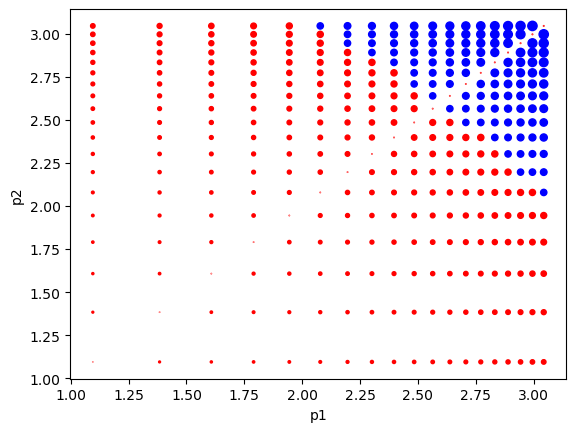

In [92]:
ped_df.assign(s=lambda d: np.abs(d['ped']) * 20) \
    .plot(
        kind='scatter', 
        x='p1', y='p2', s='s', 
        color=np.abs(ped_df['ped']).apply(lambda v: 'r' if v < 1 else 'b')
    )

In [104]:
from sklearn.linear_model import LinearRegression

Xy = np.log(df)
X = Xy[['p']]
y = Xy['q']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(5.8479080503606005, array([-0.95402491]))

<Axes: xlabel='p'>

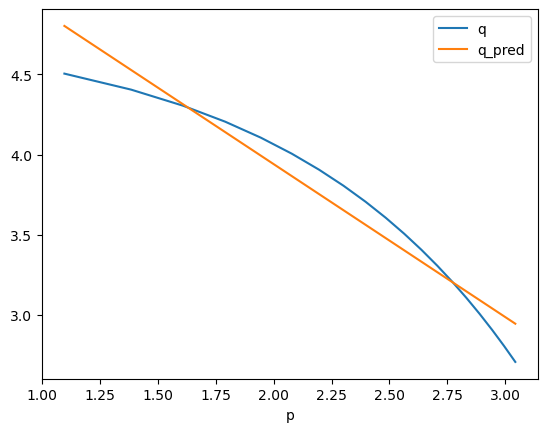

In [114]:
Xy.assign(q_pred=m.predict(X)).set_index(['p']).plot(kind='line')

In [125]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(random_state=37, n_jobs=-1, n_estimators=5)
m.fit(X, y)

RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=37)

<Axes: xlabel='p'>

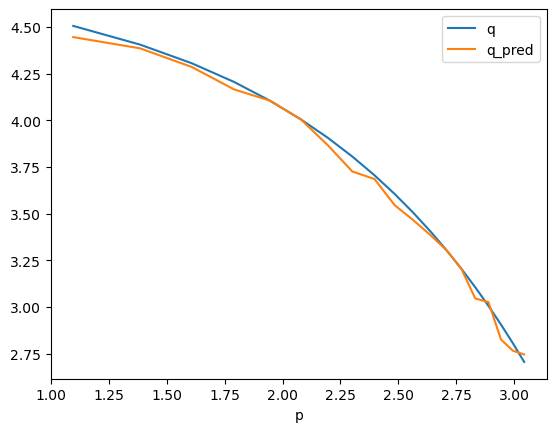

In [126]:
Xy.assign(q_pred=m.predict(X)).set_index(['p']).plot(kind='line')